In [1]:
from massa_mola_1_corpo.dataset import get_position_and_force, build_dataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
dt = 0.001
pos, force = get_position_and_force(dt=dt, c=0, f= lambda x: 0)

100%|██████████| 10000/10000 [00:03<00:00, 2983.88it/s]


In [3]:
data = build_dataset(pos, force,dt=dt)

In [4]:
q, q_dot, q_dot2, f = np.expand_dims(data.transpose(), -1)

In [5]:
f

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

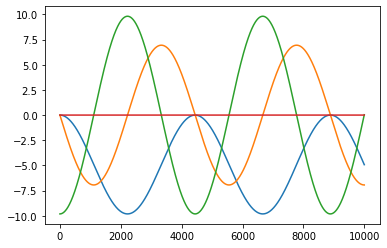

In [6]:
plt.plot(q)
plt.plot(q_dot)
plt.plot(q_dot2)
plt.plot(f)
plt.show()

In [27]:
from jax.experimental.stax import Dense, serial
import jax
import jax.numpy as jnp
import numpy as onp
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, jacobian, hessian
from jax import random
from jax.experimental import stax
from jax.experimental.optimizers import adam
from jax.tree_util import Partial

# Generate key which is used to generate random numbers
rng = random.PRNGKey(20)

In [28]:
"""

Utils

"""


def mse(y_true, y_pred):
    
    assert(jnp.squeeze(y_true).shape == jnp.squeeze(y_pred).shape)
    diff = jnp.squeeze(y_true) - np.squeeze(y_pred)
    return jnp.mean(jnp.square(diff))

"""

Neural networks

"""


def neural_network_layer(key, dim_in, dim_out, scale=1):
    w_key, b_key = random.split(key, 2)
    return random.normal(w_key, (dim_out, dim_in))*scale, random.normal(b_key, (dim_out,))*scale

def neural_network_params(key, layers, scale=1):
    keys = random.split(key, len(layers))
    return [neural_network_layer(keys[i], layers[i], layers[i+1], scale) for i in range(len(layers)-1)]


def forward_neural_network(params, x, activation_fun=jax.nn.sigmoid, scale=1):
    for w, b in params[:-1]:
        x = jnp.dot(w, x) + b
        x = activation_fun(x/1)
    w, b = params[-1]
    return jnp.dot(w, x) + b


# E.g.
params = neural_network_params(rng, layers=[6, 100, 100, 4])
forward_neural_network(params, np.array([1,2,3,4,5,6]))


"""

LNN

"""


@jit
def lag(params, q, q_dot):
    both_q = jnp.concatenate([q, q_dot], axis=-1)
    pot= forward_neural_network(params["potential"], both_q.reshape((-1,)), scale=10)
    kin = forward_neural_network(params["kinectic"], both_q.reshape((-1,)), scale=10)
    return (kin - pot)[0]

    
def forward_lagrangian(params, q, q_dot, f):
    #Lag = kin - pot
    H = jnp.squeeze(hessian(lag, argnums=1)(params, q, q_dot)).reshape(q_dot.shape[0], q_dot.shape[0])
    
    
    DqdL = jnp.squeeze(grad(lag, 1)(params, q, q_dot)).reshape((-1, 1))
    DqDq_dotL = jnp.squeeze(jacobian(jacobian(lag, 2), 1)(params, q, q_dot))
    DqDq_dotL = DqDq_dotL.reshape(q_dot.shape[0], q_dot.shape[0])
    
    return jnp.linalg.pinv(H) @ (DqdL + f - DqDq_dotL @ q_dot )
    

batch_forward_lagrangian = vmap(forward_lagrangian, in_axes=(None, 0, 0, 0), out_axes=0)

@jit
def lagrangian_mse_loss(params, q, q_dot, q_dot2, f):
    q_dot2_prediction = batch_forward_lagrangian(params, q, q_dot, f)
    return mse(q_dot2, q_dot2_prediction)

#@jit
#def loss(params, q, q_dot, q_dot2, f):
#    pred = batch_forward_pass(params, x, x_dot, f)
#    return mse(x_dot2, pred)

rng1, rgn2 = rng



In [30]:
dim = 1
potential_layers = [dim*2, 100, 100, 1]
kinectic_layers = [dim*2, 100, 100, 1]
_q=q[0]
_q_dot=q_dot[0]
_f=f[0]
rng1, rng2 = rng, rng

params_potential = neural_network_params(rng1, layers=potential_layers, scale=1000)
params_kinectic = neural_network_params(rng2, layers=kinectic_layers, scale=1000)
params={"potential": params_potential,
                           "kinectic" : params_kinectic}

l = forward_lagrangian(params={"potential": params_potential,
                           "kinectic" : params_kinectic},
                  q=_q, q_dot=_q_dot, f=_f)
batch_forward_lagrangian({"potential": params_potential,
                           "kinectic" : params_kinectic},
                        q[:10], q_dot[:10], f[:10])

DeviceArray([[[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]],

             [[0.]]], dtype=float32)

# Treinamento

In [31]:
indexes = [i for i in range(len(q))]
np.random.shuffle(indexes)

q = q[indexes]
q_dot = q_dot[indexes]
q_dot2 = q_dot2[indexes]
f = f[indexes]

undo_shuffle = onp.argsort(indexes)

Epoch 0



Epoch 0 , mean error: 48.10673


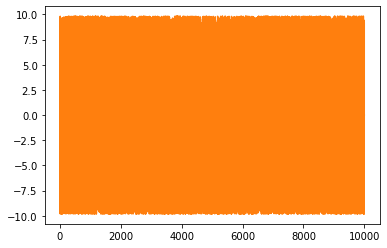

Epoch 1



Epoch 1 , mean error: 48.10673


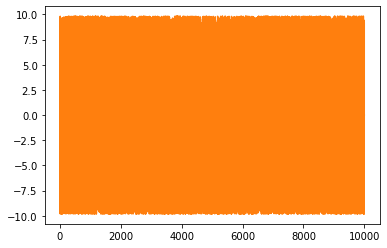

Epoch 2



Epoch 2 , mean error: 48.10673


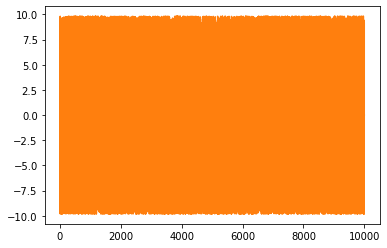

Epoch 3


KeyboardInterrupt: 

In [32]:
step_size = 0.01
batch_size = 32
epochs = 100
init_fun, opt_update, get_params = adam(step_size=step_size)


potential_layers = [dim*2, 300, 300, 300, 1]
kinectic_layers = [dim*2, 300, 300, 300, 1]
rng1, rng2 = rng, rng
params_potential = neural_network_params(rng1, layers=potential_layers, scale=1) 
params_kinectic = neural_network_params(rng2, layers=kinectic_layers)
params={"potential": params_potential,
       "kinectic" : params_kinectic}

opt_state = init_fun(params)



def train_step(q, q_dot, q_dot2, f, opt_state, opt_update):
    params = get_params(opt_state)
    mse, grad = value_and_grad(lagrangian_mse_loss)(params, q, q_dot, q_dot2, f)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state, mse


#def train_epoch(batch_size, q, q_dot, q_dot2, f, opt_state, opt_update):

epoch_errors = []
for epoch in range(epochs):

    n_batchs = len(q)//batch_size
    errors = []
  
  
    print("Epoch", epoch)
    for i in tqdm(range(n_batchs)):
        q_batch      = jnp.array(q[i*batch_size:((i+1)*batch_size)])
        q_dot_batch  = jnp.array(q_dot[i*batch_size:((i+1)*batch_size)])
        q_dot2_batch = jnp.array(q_dot2[i*batch_size:((i+1)*batch_size)])
        f_batch = jnp.array(f[i*batch_size:((i+1)*batch_size)])
        params, opt_state, error = train_step(q_batch, q_dot_batch, q_dot2_batch, f_batch, opt_state, opt_update)
        errors.append(error)
  
    mean_error = np.mean(np.array(errors))
    print("Epoch", epoch, ", mean error:",mean_error)
    epoch_errors.append(mean_error)
    
    y_pred = np.array(batch_forward_lagrangian(params, q, q_dot, f))
    plt.plot(np.squeeze(y_pred)[undo_shuffle])
    plt.plot(np.squeeze(q_dot2)[undo_shuffle])
    plt.show()
    
  

In [ ]:
def hess(params, q, q_dot):
    return jnp.linalg.pinv(jnp.squeeze(hessian(lag, argnums=1)(params, q, q_dot)).reshape(q_dot.shape[0], q_dot.shape[0]))
    
batch_hess = vmap(hess, in_axes=(None, 0, 0), out_axes=0)
batch_hess(params, q, q_dot)

In [13]:
params

[(DeviceArray([[-4.87105280e-01,  1.62394270e-02, -3.58996764e-02,
                -2.15390325e-01, -1.39771712e+00,  1.42531717e+00],
               [-4.19698954e-02,  7.25570738e-01, -5.21345794e-01,
                 1.01074135e+00, -1.30458224e+00, -2.51444459e-01],
               [ 6.01488315e-02, -6.21835947e-01,  9.24514160e-02,
                 3.49420726e-01,  9.81931463e-02, -5.32513261e-01],
               [ 1.05398941e+00, -8.08608592e-01, -1.96588945e+00,
                -1.74847043e+00,  1.27869236e+00, -1.38032353e+00],
               [ 3.88120681e-01,  1.54876983e+00, -8.90086815e-02,
                 2.15161264e-01,  4.89281952e-01,  1.40107656e+00],
               [ 1.84088063e+00,  1.36858836e-01,  1.53663456e-01,
                 6.97172821e-01, -1.32237756e+00,  8.14382613e-01],
               [-6.63943470e-01, -7.59218693e-01, -2.40540206e-01,
                -1.22755706e+00, -1.36399996e+00,  1.54113993e-01],
               [ 8.35359395e-01,  2.07824782e-01,  3.75